# Object Detection Extended Assignments
If you are working in Colab,
*   Change runtime type to GPU (_Runtime -> Change runtime type -> Hardware accelerator -> GPU -> save_)
*   Download input/helper files from (https://drive.google.com/file/d/1zeqbZRgjTBCaPoKN8qjrdCaSSJ6jv-_6/view?usp=sharing). The name of the file should be `inzva_week2.zip`
*   Open Files from left
*   Drag and drop `inzva_week2.zip` there (or click upload icon on top left). Upload can take a few minutes.
*   Unzip the file by running the following cell. **Do this even if you're not on Colab**



In [ ]:
!unzip inzva_week2.zip

In [ ]:
import sys
sys.path.insert(0,'inzva_week2')

*   If you get disconnected from the runtime, you might need to upload this file again. Also, note that this is valid for other local files too eg. repos that have been cloned, files generated during execution etc. In short, if you see that your files are gone after a while, just run the cell that generates, clones, etc. the missing files again.

## A) Video Object Detection

### Question: Video object detection with Kalman filter and YOLO

You have seen last week that YOLO [9] is a single stage object detector. In case you were wondering if we can use object detectors on images for videos, although there exist better solutions, the answer is yes!

However, using only YOLO on each individual frame has a disadvantage: the resulting object bounding boxes might not be smooth as temporal information is not used. Therefore, we can incorporate YOLO with Kalman filter [10]. Kalman filter is an estimation algorthm which will improve YOLO results by smoothing them.

After running the cells for this question, the output file `out.avi` should be downloaded to your local machine. You can open the video on your machine to see the outcome.

In [ ]:
# Install source code that we will use
!git clone https://github.com/cfotache/pytorch_objectdetecttrack.git
%cd pytorch_objectdetecttrack
# Download YOLO weights
!bash config/download_weights.sh
!mv yolov3.weights config/
# Install filterpy for kalman filter
!pip install filterpy==1.4.5

In [ ]:
# Download the video that we will use
!wget https://motchallenge.net/sequenceVideos/MOT16-09-raw.webm
!mkdir video
!mv MOT16-09-raw.webm video/MOT16-09-raw.webm

In [ ]:
from models import *
from utils import *
import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from google.colab import files

In [ ]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4
# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

In [ ]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms=transforms.Compose([transforms.Resize((imh,imw)),
         transforms.Pad((max(int((imh-imw)/2),0), 
              max(int((imw-imh)/2),0), max(int((imh-imw)/2),0),
              max(int((imw-imh)/2),0)), (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, 
                        conf_thres, nms_thres)
    return detections[0]

**Question:** Add bounding boxes and labels for the detected objects.

In [ ]:
videopath = 'video/MOT16-09-raw.webm'
%pylab inline 
import cv2
from IPython.display import clear_output
cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]
# initialize Sort object and video capture
from sort import *
vid = cv2.VideoCapture(videopath)
out = cv2.VideoWriter('out.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 20.0,(int(vid.get(3)),int(vid.get(4))))
mot_tracker = Sort()
for k in range(140):
    ret, frame = vid.read()
    pilimg = Image.fromarray(frame)
    detections = detect_image(pilimg)
    img = np.array(pilimg)
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    if detections is not None:
        tracked_objects = mot_tracker.update(detections.cpu())
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
            ##################################################################
            ###                      YOUR CODE STARTS                      ###
            ##################################################################
            # TODO: Put rectangle around object

            # TODO: Put text on top of the rectangles. It should denote both the
            # class and its ID
            
            ##################################################################
            ###                       YOUR CODE ENDS                       ###
            ##################################################################
    out.write(frame)
files.download('out.avi')

In [ ]:
# Go to up directory as we're done with this question
%cd ..

/content


### Question
You have seen last week that there are exist other object detection architectures like CornerNet and Faster R-CNN. What might be the advantage and disadvantage of using YOLO over them for video object detection task?

**Answer**: 

### Question
One weakness of convolutional neural networks (CNNs) is that they have fixed geometric structures in their building modules, hence, rely on data augmentation to learn geometric transformations. The transformation modeling capability of CNNs can be improved by deformable convolution [3, 4, 5]. Deformable convolutions are widely used in various tasks such as video object detection [6] and semantic segmentation [7].  


Why is deformable convolution good for object detection?


<img src="https://drive.google.com/uc?export=view&id=1UFEtx9AhuLUAjoY-B9JFHpceLLEQdaV8" alt="Deformable Convolution" width="400"/>


**Answer**:

## B) 3D Object Detection
3D data is used in computer vision extensively as it provides rich information about the objects and scenes. 

There are numerous ways to represent 3D data such as point clouds, voxels, meshes, signed distance fields, and descriptors [2].

### Visualizing 3D data
Throughout this part, you will create mesh files (the ones with `ply` extension) for storing 3D data. You can visualize it through eg. MeshLab or Open3D. We suggest you to visualize `ply` files in your local machine as it is challenging in a notebook.   

Using MeshLab,
*   Install MeshLab: https://www.meshlab.net/#download
*   Visualize ply files: dragging `ply` file into an open MeshLab window should work.

Using Open3D,   
*   Install Open3D: http://www.open3d.org/docs/release/getting_started.html
*   Visualize ply file: http://www.open3d.org/docs/latest/tutorial/Basic/file_io.html#Mesh



### Pinhole Camera Model

A distance (depth) map can be collected through depth sensors, and it provides the metric distance values for each pixel. 

Pinhole camera model with a focal length $f$ and center $c$ projects 3D world points to an image plane by the following model:

<figure>
  <img src="https://miro.medium.com/max/1400/1*hQv3DIq0ClYb7I_SUBBN4w.png" alt="3D Bounding Box" width="800">
</figure>

Given an image with 2D coordinates $x, y$, we can calculate 3D point world coordinates $X,Y,Z$ by following:

\begin{equation}
u = f_{x}\frac{X}{Z}+c_{x} \quad v = f_{y}\frac{Y}{Z}+c_{y} .
\end{equation}

In a matrix notation, camera's intrinsic parameters are collected within matrix $K$, pixel coordinates $p$ and 3D coordinates in camera coordinates $P_{c}$, and equation can be shown by $s * p = K * P_{c}$:

\begin{equation}
  s \begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = \begin{bmatrix} {f_x}& {0}& {c_x} \\ {0}&{f_y}&{c_y} \\ {0}&{0}&{1} \end{bmatrix} \begin{bmatrix} {X_c} \\{Y_c}\\{Z_c} \end{bmatrix}
\end{equation}


Usually, the 3D points are represented within a canonical world coordinate system, and a camera views the points from a pose represented by a rotation $R$ and translation $t$ with respect to the world coordinates. This can be shown by camera extrinsic parameters matrix:

\begin{equation}
  \begin{bmatrix} R & t \\ 0 & 1 \end{bmatrix} = \begin{bmatrix} r_{11} & r_{12} & r_{13} & t_x \\ r_{21} & r_{22} & r_{23} & t_y \\ r_{31} & r_{32} & r_{33} & t_z \\ 0 & 0 & 0 & 1 \end{bmatrix}
\end{equation}

And finally, we can calculate the full perspective projection between 3D points in world coordinates $P_{w}$ and 2D pixels in image coordinates $p$ by:
\begin{equation}
s*p = K * [R | t] * P_{w}
\end{equation}  

You can check [11] for further information. There is an interactive demo which gives an intuition on the intrinsic parameters of the camera, $K$. The interactive demo in [12] gives an intuition on the extrinsic parameters, $R$ and $t$.


**Question:** Explicitly write out the last formula with full matrices. Does it work? Do you need to manipulate/add any dimensions to make it work? 

**Answer:**

### Point Cloud

Point cloud is a structure that holds (X,Y,Z) coordinates of a 3D shape. It can be extracted from a distance map or a 3D scanning device. Lidar is such a special 3D scanning technology commonly used in autonomous driving setting.

<figure>
  <img src="https://www.mercurynews.com/wp-content/uploads/2019/06/SJM-L-SELFDRIVE-3.jpg?w=620" alt="3D Bounding Box" width="300">
</figure>


**Question:** Now, looking at the figure and assuming we have the camera intrinsics, implement the backprojection to return a point cloud of shape [height, width, 3]. Keep in mind that we **project** a 3D point to a pixel in 2D image whereas we **backproject** a pixel in 2D image to a 3D point. 

In [ ]:
def backproject(depth, intrinsics):
    height, width = depth.shape[0], depth.shape[1]
    point_cloud = np.zeros([height, width, 3])
    fx, fy = intrinsics[0,0], intrinsics[1,1]
    v0, u0 = intrinsics[0,2], intrinsics[1,2]
    
    ##################################################################
    ###                      YOUR CODE STARTS                      ###
    ##################################################################

  

    ##################################################################
    ###                      YOUR CODE ENDS                      ###
    ##################################################################
    return point_cloud

**Question:** Here is an indoor image (`inzva_week2/debug_image.png`) and a depth map (distance map) (`inzva_week2/debug_depth.tiff`) from NYU v2 dataset. Try out your backprojection method below. After running this cell, `debug_cloud.ply` should be downloaded to your machine. You can visualize it via Meshlab or Open3D. If you don't have any software for visualizing 3D data, follow `Visualizing 3D data` section above. The resulting point cloud should look like this:

<img src="https://drive.google.com/uc?export=view&id=1hCUb4X-BO3pCEwo4FnKHDRE2DFRRfbG-" width="500">

Note that the color of points might look different depending on eg. shading.

In [ ]:
import cv2
import numpy as np
from PIL import Image
from kitti_frustum import write_pointcloud

fx = 517.3
fy = 516.5
centerX = 318.6
centerY = 255.3

intrinsics = np.matrix([[fx, 0, centerX],
                      [0, fy, centerY],
                      [0, 0, 1]])

rgb = cv2.imread("inzva_week2/debug_image.png") 
depth = np.array(Image.open("inzva_week2/debug_depth.tiff"))

pcd = backproject(depth, intrinsics)

pcd = pcd.reshape(-1, pcd.shape[-1])
rgb = rgb.reshape(-1, rgb.shape[-1])

ply_file =  "debug_cloud.ply"
write_pointcloud(ply_file, pcd, rgb) # this function requires input points of Nx3.
files.download(ply_file)

### Voxels

Voxels are another way to represent the 3D data, which is basically a 3D image. Can you guess where the word "voxel" comes from? 

<figure>
  <img src="https://o.aolcdn.com/images/dims?quality=95&image_uri=https%3A%2F%2Fs.yimg.com%2Fos%2Fcreatr-uploaded-images%2F2020-05%2Fa326b0d0-991b-11ea-bfce-920b4e12e12f&client=amp-blogside-v2&signature=5a33c4b2b60de1f99e3950c3fbac16bdd0ddd563" alt="3D Bounding Box" width="300">
</figure>


**Question:**  How can we convert a point cloud to a voxel, briefly explain. You can check Open3D libraries and implementations to learn more. 


**Answer**:

**Question**: What would be a simple way to process voxel data in deep learning? Can you name other data types that this structure is helpful?

**Answer**: 

### Mesh

Mesh is another common way to represent data. It is similar to a pointcloud, yet it includes only the surface points, and connects them to each other. In other words, it represents 3D shape through edge and vertices. 

<figure>
  <img src="https://humaan.com/wp-content/uploads/2016/02/bunny-resolutions.jpg" alt="3D Bounding Box" width="200">
</figure>


**Question:** What is the name of the data structure to keep a mesh data? Can you name a way to deal with such data in deep learning? 


**Answer**: 

### Comparison


**Question**: Can you compare point cloud, mesh and voxel in terms of memory requirements and representation capabilities? 
 


**Answer**: 

### PointNet

PointNet [1] is a prominent paper on point cloud processing (more specifically, applying deep learning to point clouds) for object classification, part segmentation, and scene semantic parsing.


**Question**: Can we use 2D convolutions on depth map?

**Answer**: 

**Question**: Can we use 3D convolutions on point clouds? 

**Answer**: 

**Question**: How does PointNet handle the unordered nature of point clouds? (hint: how is permutation invariance ensured?)

**Answer**: 

**Question**: Let's dive into PointNet now. Below, we define the architecture, which consists of T-Net and feature extraction modules. We share a sample pointcloud from ModelNet dataset and a pretrained PointNet module. Apply prediction on the given point cloud. Here is how the given point cloud looks like:

<img src="https://drive.google.com/uc?export=view&id=1L0sHm91Ky-Fpi4xZEEwY9hEAepm0GLeP" width="500">

<img src="https://drive.google.com/uc?export=view&id=1DbqqNbw8Z3jx4Me0anCPMorjEFhuuPAT" width="500">

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

# implementation from https://github.com/nikitakaraevv/pointnet

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

sample_pointcloud = np.load('inzva_week2/pointnet_pc_sample.npy')

pointcloud = torch.from_numpy(sample_pointcloud).float()
inputs = pointcloud.unsqueeze(0).transpose(1,2).to(device)

pointnet = PointNet()
pointnet.to(device)

pointnet.load_state_dict(torch.load('inzva_week2/pointnet_pretrained.pth'))
pointnet.eval()

In [ ]:
# TODO: Obtain inference from pointnet model for the given input

# TODO: Get the index of predicted class and assign it to a variable called cls.
# You will use cls in the next cell
_, preds = 
cls = preds.detach().cpu().numpy()[0]

In [ ]:
classes = {0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

print(classes[cls])

In [ ]:
# TODO: Now, extract the latent vector from pointnet.transform() layer.
# Then, shuffle the points and apply inference again.
# Compare the latent vector with the previous (unshuffled) point. 




### How can we detect objects in 3D?

**a)**: Can we use only 2D images from the frontal view? Would it be enough to reason in 3D?

**Answer**: 

**b)**: What if we have a depth or Lidar sensor to collect a point cloud of the scene in addition to 2D images?

**Answer**: 

**c)**: What are the problems with data collected from Lidar sensor?

**Answer**: 

**d)**: Another way to use Lidar is Bird's eye view projection. How can this be used? What are possible problems? 

**Answer**: 

**e)**: It is also possible to use a depth estimator (ie. monocular depth predictor) to extract a point cloud. These methods are called "pseudo-Lidar". Compare such an approach with Lidar. 

**Answer**:  

To sum up, two main approaches for object detection on 3D point cloud data are either (i) projecting data to a 2D view (eg. birds eye view) then detecting objects on 2D image or (ii) detecting object directly on 3D point cloud data.

**Question**: Compare these approaches, what are the advantages&disadvantages in terms of computation, accuracy, other factors.

**Answer**: 

### Question: 3D Bounding Box Parametrization
How many parameters are required for finding the bounding box which encapsulates an object? Briefly justify your answer.

<figure>
  <img src="https://raw.githubusercontent.com/sk-aravind/3D-Bounding-Boxes-From-Monocular-Images/master/cover_img.jpg" alt="3D Bounding Box" width="600">
</figure>

**Answer**: 

**Question:** Calculate the 8 corner points of a bounding box from its parametrization, in the given order below. Visualize your bounding boxes by the provided code which reads a KITTI [13] sample file. Parameters are given in camera coordinate frame: x right, y down, z forward. Assume that x and z coordinates are given centered, y starting from ground.
```
            7 -------- 4
           /|         /|
          6 -------- 5 .
          | |        | |
height(y) . 3 -------- 0
          |/         |/ width (z)
          2 -------- 1
            length (x) 
```




In [ ]:
def rotation_y(t):
  ''' TODO: implement this part '''


  return R

def get_corners3d(l, w, h, heading, centerx, centery, centerz):
    ''' TODO: 
          1. Retrieve the rotation matrix from the heading angle.
          2. Create x,y,z corner points with given dimensions.
          3. Apply the heading rotation to the points.
          4. Translate by center coordinates. '''
    
    return corners_3d

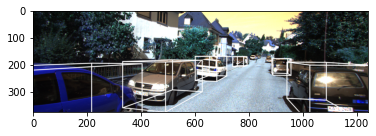

In [ ]:
import kitti_boxes as kb
import matplotlib.pyplot as plt

# load the sample Kitti file. 
# left_cam: image from left camera
# velo: velodyne point clouds 
# objects: ground truth objects, see the file "kitti_boxes.py" Object3D class.
# calibd: calibration parameters required for camera/velodyne coordinate conversions.
left_cam, velo, objects, calib_data = kb.loadKittiFiles()

img_new = np.copy(left_cam)
P2_rect = calib_data.P
for obj in objects:
    if obj.type == 'DontCare': continue
    corners_3d = get_corners3d(obj.l, obj.h, obj.w, obj.ry, obj.t[0], obj.t[1], obj.t[2])
    corners_2d = kb.get_corners2d(corners_3d, P2_rect)
    img_new = kb.draw_projected_box3d(img_new, corners_2d)

plt.imshow(img_new)

**Question:**

3D bounding box prediction is usually evaluated with 3D IoU metric. What are the differences with 2D IoU, which extra values and calculations are required? (optional: try to code it up!)

**Answer:**

https://varunagrawal.github.io/bbox/_modules/bbox/metrics.html#jaccard_index_3d

https://github.com/AlienCat-K/3D-IoU-Python/blob/master/3D-IoU-Python.py

### Frustum PointNets 

FrustumNet is a method that operates on 3D data, ie. point clouds. But as the initial proposal extraction step is costly on 3D, they collect the proposals from 2D image [8], and lift these to 3D as can be seen here:

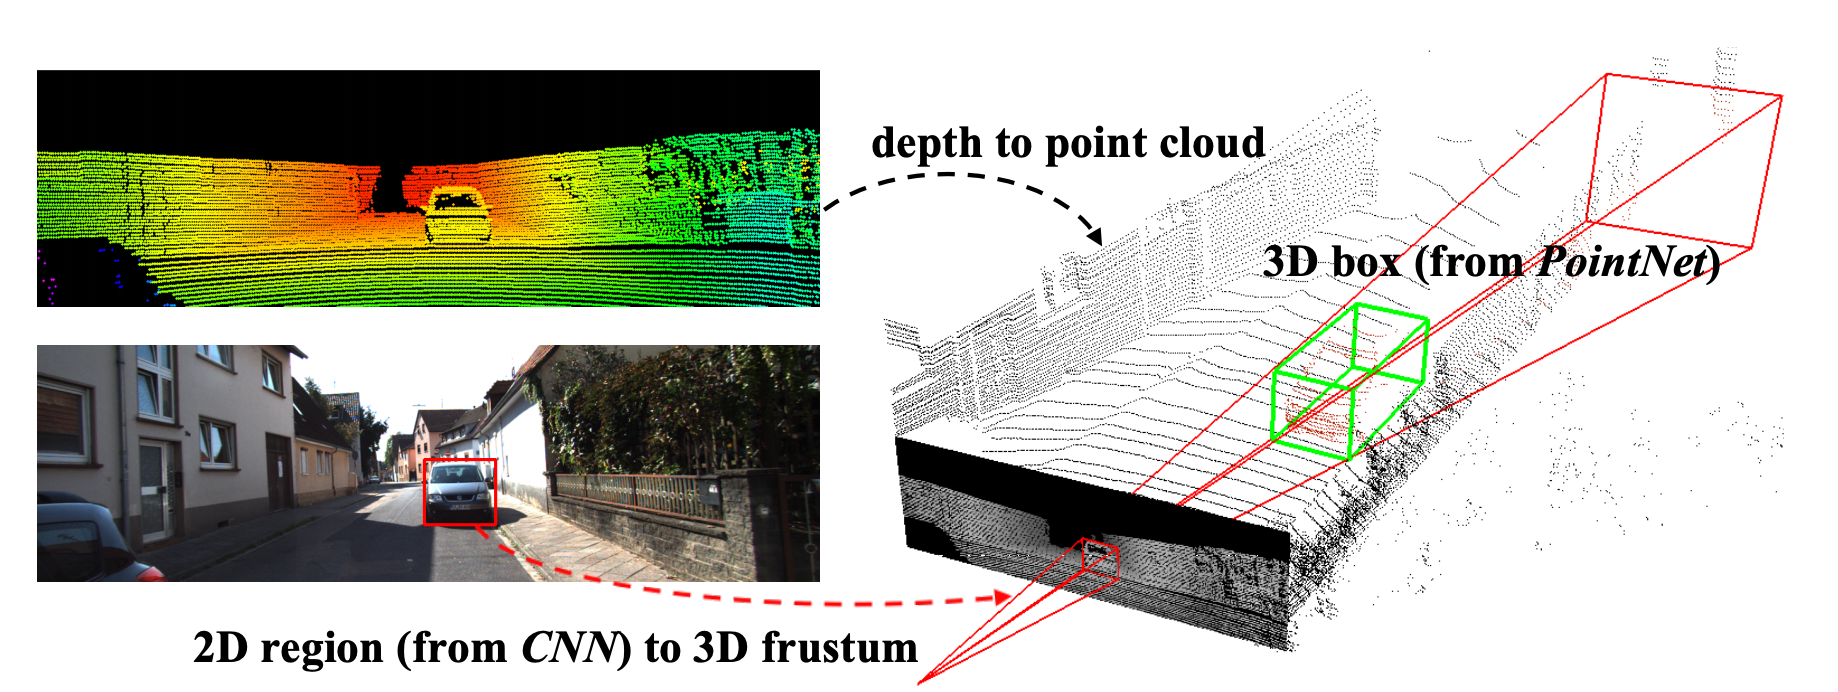

**Question:** Implement ground truth object point cloud extraction function which takes a point cloud and a ground truth 3D bounding box and returns the points within the bounding box. (hint: check out scipy Delaunay triangulation function).

In [ ]:
# There is a full velodyne point cloud sample given with the repository. 
# You can visualize it with MeshLab.

def in_bounding_box(pc, bounding_box_3d):
    ''' Input: a point cloud and 3d bounding box coordinates,
        Output: boolean vector to show whether points are lying in the bb.
        '''
    from scipy.spatial import Delaunay

    ### TODO: Your code starts here.
    

    return simpl

def extract_object(pc, bounding_box_3d):
    ''' Input: pc: (N,3), bounding_box_3d: (8,3) 
        Output: point cloud within the pc, and indices
    '''
    ### TODO: Your code starts here.
    
    return pc_in, box3d_roi_inds


In [ ]:
from kitti_frustum import *
from kitti_calibration import *

# Load the velodyne points, extract the points in the image field of view.
# note that, we need to convert velodyne coordinate to rectified camera coordinates.
pc_rect = np.zeros_like(velo)
pc_rect[:, 0:3] = calib_data.project_velo_to_rect(velo[:, 0:3])
pc_rect[:, 3] = velo[:, 3]
img_height, img_width, img_channel = img_new.shape
fov_velo_pcd, pc_image_coord, img_fov_inds = get_lidar_in_image_fov( \
    velo[:, 0:3], calib_data, 0, 0, img_width, img_height, True)

# Extract the object points from given bounding boxes and visualize the point cloud.
for i in range(len(objects)):
    obj = objects[i]
    if obj.type == 'DontCare': continue
    corners_3d = get_corners3d(obj.l, obj.h, obj.w, obj.ry, obj.t[0], obj.t[1], obj.t[2])
    gt_obj_pcd, roi_inds = extract_object(pc_rect, corners_3d)
    print("gt pc in bb: ", gt_obj_pcd.shape, roi_inds.sum())
    ply_file =  "obj_gt_"+str(i)+".ply"
    write_pointcloud(ply_file, gt_obj_pcd[:,:3])

**Question:** Implement proposal frustum extraction function which takes a depth map and 2D bounding box and returns points in the frustum.

In [ ]:
# 2d bounding boxes are given in xmin, ymin, xmax, ymax = obj.box2d
# img_fov_inds is a boolean matrix which shows if a point is within FOV,
# use this information while selecting the box points.

def proposal_frustum(bounding_box_2d, rect_points, pc_image_coord, img_fov_inds):
  ''' TODO: implement this part '''
  
  return frustum

for obj_idx in range(len(objects)):
    # 2D BOX: Get pts rect backprojected
    bounding_box_2d = objects[obj_idx].box2d
    frustum_points = proposal_frustum(bounding_box_2d, pc_rect, pc_image_coord, img_fov_inds)
    print("pc in bb: ", frustum_points.shape)
    ply_file = "obj_frustum_" + str(obj_idx) + ".ply"
    write_pointcloud(ply_file, frustum_points[:,:3])

**Question:** Rotate the frustum points so that the center axis is orthogonal to the image plane. (hint: This corresponds to a rotation along y axis).

In [ ]:
def calculate_angle(box2d, calib):
  ''' 
      TODO: Frustum angle calculation, hint: np.arctan might help here!'''
  
  return frustum_angle

def normalize_frustum_angle(frustum, box2d, calib):
  ''' frustum : [N, 3]
      
      TODO: Calculate the frustum angle, apply rigid body transformation
      to the points within frustum to align with the camera.'''
  
  return frustum

During discussion time: 

- Lidar to 2D projection
- 3D BB projections on image / Mayavi Lidar visualizations

### References
[1] Qi, Charles R., et al. "Pointnet: Deep learning on point sets for 3d classification and segmentation." _Proceedings of the IEEE conference on computer vision and pattern recognition_. 2017.  
[2] Ahmed, Eman, et al. "A survey on deep learning advances on different 3D data representations." _arXiv preprint arXiv:1808.01462_ (2018).  
[3] Dai, Jifeng, et al. "Deformable convolutional networks." _Proceedings of the IEEE international conference on computer vision_. 2017.  
[4] https://youtu.be/HRLMSrxw2To  
[5] https://medium.com/@phelixlau/notes-on-deformable-convolutional-networks-baaabbc11cf3  
[6] Gedas Bertasius, Lorenzo Torresani, and Jianbo Shi. Object
detection in video with spatiotemporal sampling networks.
_ECCV_, 2018.  
[7] Jifeng Dai, Haozhi Qi, Yuwen Xiong, Yi Li, Guodong
Zhang, Han Hu, and Yichen Wei. Deformable convolutional
networks. _ICCV_, 2017. 

[8] Qi et al. "Frustum PointNets for 3D Object Detection from RGB-D Data".  
[9] Redmon, Joseph, et al. "You only look once: Unified, real-time object detection." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.   
[10] https://www.kalmanfilter.net/default.aspx  
[11] http://ksimek.github.io/2013/08/13/intrinsic/   
[12] http://ksimek.github.io/2012/08/22/extrinsic/   
[13] http://www.cvlibs.net/datasets/kitti/